C:\Users\micha\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


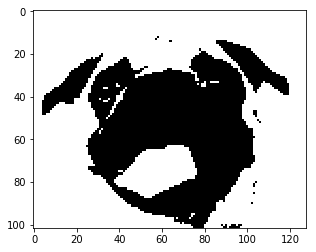

In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.misc import imread

originalImage = imread('pug.png')
originalImage = originalImage/255
fig = plt.figure
plt.imshow(originalImage, cmap='gray')


In [14]:
def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] += e[index]
    
    return im2
def add_saltnpepper_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1 - im2[index]
    
    return im2

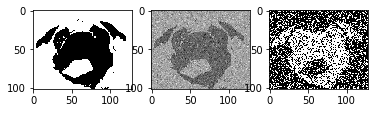

In [42]:
prop = 0.75
varSigma = 0.4

gaussImage = add_gaussian_noise(originalImage,prop,varSigma)
saltyImage = add_saltnpepper_noise(originalImage,prop)

threeFigs = plt.figure()
ax = threeFigs.add_subplot(131)
ax.imshow(originalImage, cmap = 'gray')

ax2 = threeFigs.add_subplot(132)
ax2.imshow(gaussImage, cmap = 'gray')
ax3 = threeFigs.add_subplot(133)
ax3.imshow(saltyImage, cmap = 'gray')

In [43]:
def neighbours(i,j,M,N,size=4):
    # Can expand to size = 8 if i fancy for better results :)
    if size == 4:
        if (i == 0 and j == 0):
            n = [(0,1),(1,0)]
        elif i == 0 and j == N-1:
            n = [(0,N-2),(1,N-1)]
        elif i == M-1 and j == 0:
            n = [(M-1,1),(M-2,0)]
        elif i == M-1 and j == N-1:
            n = [(M-1,N-2),(M-2,N-1)]
        elif i == 0:
            n = [(0,j-1),(0,j+1),(1,j)]
        elif i == M-1:
            n = [(M-1,j-1),(M-1,j+1),(M-2,j)]
        elif j == 0:
            n = [(i-1,0),(i+1,0),(i,1)]
        elif j == N-1:
            n = [(i-1,N-1),(i+1,N-1),(i,N-2)]
        else:
            n = [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]
            
        return n
    elif size == 8:
        if (i == 0 and j == 0):
            n = [(0,1),(1,1),(1,0)]
        elif i == 0 and j == N-1:
            n = [(0,N-2),(1,N-1),(1,N-1)]
        elif i == M-1 and j ==0:
            n = [(M-1,1),(M-2,1),(M-2,0)]
        elif i == M-1 and j == N-1:
            n = [(M-1,N-2),(M-2,N-2),(M-2,N-1)]
        elif i == 0:
            n = [(0,j-1),(1,j-1),(0,j+1),(1,j+1),(1,j)]
        elif i == M-1:
            n = [(M-1,j-1),(M-2,j-1),(M-1,j+1),(M-2,j+1),(M-2,j)]
        elif j == 0:
            n = [(i-1,0),(i-1,1),(i+1,0),(i+1,1),(i,1)]
        elif j == N-1:
            n = [(i-1,N-1),(i-1,N-2),(i+1,N-1),(i+1,N-2),(i,N-2)]
        else:
            n = [(i-1,j),(i-1,j-1),(i+1,j),(i+1,j+1),(i,j-1),(i+1,j-1),(i,j+1),(i-1,j+1)]
             
        return n      

In [44]:
def EoX(Image, HiddenImage, Coord):
    A = HiddenImage.shape[0]
    B = HiddenImage.shape[1]
    TotalPixels = A*B #Shape of Image and HiddenImage are equivalent :)
    Neighbours = neighbours(Coord[0],Coord[1],A,B,8)
    #print(Neighbours)
    energy = 0
    for dude in Neighbours:
        x_n = dude[0]
        y_n = dude[1]
        #print(dude)
        energy += HiddenImage[Coord[0],Coord[1]]*HiddenImage[dude[0],dude[1]]
    energy = -energy/TotalPixels
    return energy

def TotalE (Image, HiddenImage):
    energy = 0
    A = Image.shape[0]
    B = Image.shape[1]
    #print([A, B])
    #print(list(range(A)))
    for a in range(A):    
        for b in range(B):
            Coord = [a,b]
            energy += EoX(Image, HiddenImage, Coord)
    return energy

#SecretPic = np.copy(gaussImage)




In [49]:
def ICMaPoint (Image, HiddenImage, Coord, Energy):
    currentE = EoX(Image, HiddenImage,Coord)
    diffE = Energy - currentE
    
    #Flipped Version of HiddenImage
    HidingHiddenImage = np.copy(HiddenImage)
    if HiddenImage[Coord[0],Coord[1]] == 1:
        HidingHiddenImage[Coord[0],Coord[1]] = 0
    else:
        HidingHiddenImage[Coord[0],Coord[1]] = 1  
    #Does flipping the pixel reduce the energy?
    flippedE = EoX(Image, HidingHiddenImage, Coord)
    
    if flippedE < currentE:
        FLIP = True
        Energy = diffE + flippedE
        HiddenImage = HidingHiddenImage
    else:
        FLIP = False
        
    return (HiddenImage,FLIP,Energy)

Total Energy -4.929304534313477
Whats the matter? Giving UP so soooon?


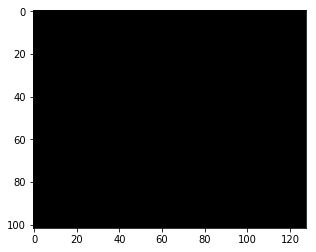

In [50]:
workImage = saltyImage # CHANGE THIS ONE!
MaxIters = 10


#workImage[workImage <= 0.5] = -1 #make the issue a closed discrete form
#workImage[workImage > 0.5] = 1
hiddenIm = np.copy(workImage)


TotalEnergy = TotalE(workImage,hiddenIm)
energyNow = TotalEnergy 

[A,B] = gaussImage.shape

#print(A)
for Iters in range(MaxIters):
    for a in range(A):
        for b in range(B):
            Coord = [a,b]
            hiddenIm, Flip, TotalEnergy = ICMaPoint(workImage,hiddenIm,Coord,TotalEnergy)
            #print(b)
        #print(a)
    if (TotalEnergy - energyNow) == 0:
        print("Whats the matter? Giving UP so soooon?")
        break
    energyNow = TotalEnergy
    print("Total Energy",TotalEnergy)
    
fig = plt.figure
plt.imshow(hiddenIm, cmap='gray')

In [47]:
print(hiddenIm)
print(workImage)
print(workImage[1][0])

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 1. 0. 1.]]
0.0
